This notebook presents the application of the proposed proforma to a potential high-rise condo project at the City of Toronto. For more information and interpretation of the results, please refer to the following paper using [this link](https://www.mdpi.com/1911-8074/16/10/446).

*   Valaei Sharif, S., Parker, D. C., Waddell, P., & Tsiakopoulos, T. (2023). Understanding the Effects of Market Volatility on Profitability Perceptions of Housing Market Developers. *Journal of Risk and Financial Management*, 16(10), 446.



In [1]:
%pip install numpy-financial
%pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 8.2 MB/s eta 0:00:00


In [4]:
# Importing the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.ticker as mticker
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from proforma import proforma
from functions import *
import time as t
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Loading the input datasets
path=os.chdir('/content/drive/My Drive/Mitacs_Fall2022/Public-Development-Proforma/input_data/')
construction_cost_data_df = pd.read_excel('proforma_inputs.xlsx', sheet_name='construction_cost_data')
construction_cost_data_df['Price'] = construction_cost_data_df['VALUE']*(275/100)
construction_cost_data_df['DATE'] = pd.to_datetime(construction_cost_data_df['REF_DATE'])
vacancy_rates_data_df = pd.read_excel('proforma_inputs.xlsx', sheet_name='vacancy_rate_data')
vacancy_rates_data_df.sort_values('REF_DATE', inplace=True)
vacancy_rates_data_df.reset_index(drop=True, inplace=True)
rent_data_df = pd.read_excel('proforma_inputs.xlsx', sheet_name='rent_data')
absorption_rate_data_df = pd.read_excel('proforma_inputs.xlsx', sheet_name='absorption_rate_data')
desired_months = [1, 4, 7, 10]  # Months to keep
mask = absorption_rate_data_df['REF_DATE'].dt.month.isin(desired_months)
absorption_rate_data_df = absorption_rate_data_df[mask]
absorption_rate_data_df.reset_index(drop=True, inplace=True)
sales_data_df = pd.read_excel('proforma_inputs.xlsx', sheet_name='sales_data')
window_size = 3
sales_data_df['moving_average'] = sales_data_df['Median'].rolling(window=window_size).mean()
desired_months = [1, 4, 7, 10]  # Months to keep
mask = sales_data_df['REF_DATE'].dt.month.isin(desired_months)
sales_data_df = sales_data_df[mask]
sales_data_df.reset_index(drop=True, inplace=True)
sales_data_df['Average'] = sales_data_df['moving_average']
interest_rate_data_df = pd.read_excel('proforma_inputs.xlsx', sheet_name='interest_rate_data')

# Importing the input parameters to the proforma
proforma_inputs_df = pd.read_excel('/content/drive/My Drive/Mitacs_Fall2022/Public-Development-Proforma/input_data/proforma_inputs.xlsx', sheet_name='Scenarios_sales', index_col=0)

In [7]:
# Specifying different scenarios to be represented in the example
scenarios = proforma_inputs_df.columns.to_list()[2:13]
labels = ['Perfect', 'Naive', 'Mean', 'Cycle', 'Projection', 'Re-scale', 'Adaptive', 'Weak-trend', 'Strong-trend', 'Anchor', 'GARCH']

In [8]:
# Setting up the fonts and chart representations
sns.set_style("ticks")
plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams.update({'font.serif':'Palatino Linotype'})
font_size = 26
plt.rcParams.update({
    'font.size': font_size,             # Controls default text size
    'axes.titlesize': font_size,        # Font size of the title
    'axes.labelsize': font_size,        # Font size of the x and y labels
    'xtick.labelsize': font_size,       # Font size of the x-axis tick labels
    'ytick.labelsize': font_size,       # Font size of the y-axis tick labels
    'legend.fontsize': font_size        # Font size of the legend
})

In [9]:
# Representing a table of input parameters
proforma_input_table = proforma_inputs_df[['Variable', 'Description', 1]].dropna()
proforma_input_table.drop(['cc_model', 'rp_model', 'vr_model', 't_d',
                            'R',
                            'PT',
                            'N_cc_model',
                            'd',
                            'N_rp_model',
                            'U_c',
                            'N_vr_model',
                           'i_model',
                           'N_i_model'],
                            axis=0, inplace=True)
proforma_input_table = proforma_input_table.rename(columns={'Variable': 'Description', 'Description': 'Variable unit', 1: 'Variable value'})
proforma_input_table.style.format({'Variable value': '{:,.2f}'})

,Description,Variable unit,Variable value
Notation,,,
A,Land size,Acres,2.50
Ns,Number of small units (bachelor and 1 bedroom),Units,179.00
Nl,Number of large units (2+ bedroom),Units,178.00
N,Total units to sell,Units,357.00
A_a,Average unit area,Square feet,700.00
tau,Construction costs,Dollar per square foot,298.93
L,Land acquisition costs,Dollar,"60,000,000.00"
P,Planning and design,Dollar,"1,150,000.00"
Ds,Development charges per small units (bachelor and 1 bedroom),Dollar,"13,645.00"


# 1 Construction cost expectations

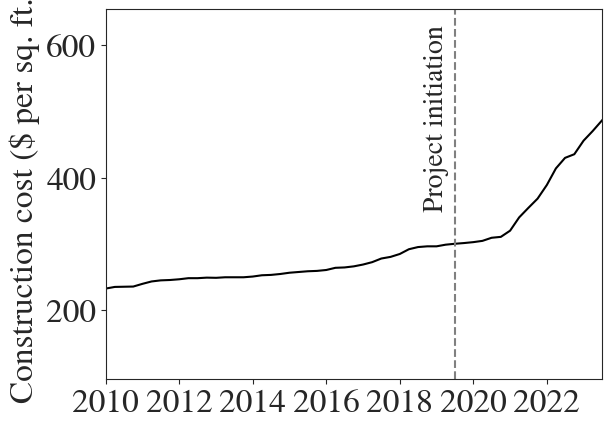

In [ ]:
plt.plot(construction_cost_data_df['DATE'], construction_cost_data_df['Price'], color='black')
plt.xlim(datetime(2010, 1, 1), datetime(2023, 7, 1))
plt.gca().set_ylabel('Construction cost ($ per sq. ft.)')
plt.axvline(x=datetime(2019, 7, 1), color='gray', linestyle='--')
plt.text(datetime(2019, 1, 1), 350, 'Project initiation', ha='center', va='bottom', rotation=90, size=20)
plt.savefig('cc_hist.png', dpi=300, bbox_inches='tight')

In [ ]:
# Setup a test proforma to be used for different experiments with the construction cost expectation mechanisms
test_proforma = proforma(proforma_inputs_df,
                         construction_cost_data_df=construction_cost_data_df, construction_cost_data_type='index', cc_price_base=275,
                         vacancy_data_df=vacancy_rates_data_df,
                         absorption_data_df=absorption_rate_data_df,
                         rent_data_df=rent_data_df,
                         sales_data_df=sales_data_df,
                         interest_rate_data_df=interest_rate_data_df)

## 1.1 Parameterization

In [ ]:
cc_rescale_factors = []
# Parameterization of the re-scale model
start_index_init = 142
end_index_init = 154
for i in range(16):
  observation = construction_cost_data_df[['DATE', 'Price']][start_index_init+i:end_index_init+i]
  step = []
  for j in range(start_index_init+i, end_index_init+i):
    step.append(construction_cost_data_df['Price'][j] / construction_cost_data_df['Price'][j-1])
  observation['step'] = step
  cc_rescale_factors.append(observation[10:]['step'].mean())

In [ ]:
observation = construction_cost_data_df[['DATE', 'Price']][start_index_init:end_index_init]
step = []
for j in range(start_index_init, end_index_init):
  step.append(construction_cost_data_df['Price'][j] / construction_cost_data_df['Price'][j-1])
observation['step'] = step
print('rescale factor for 12 periods: ', observation['step'].mean())
print('rescale factor for 4 periods: ', observation[8:]['step'].mean())
print('rescale factor for 2 periods: ', observation[10:]['step'].mean())

rescale factor for 12 periods:  1.010431873913985
rescale factor for 4 periods:  1.005843155969294
rescale factor for 2 periods:  1.00417439703154


Scenario 1 completed . . .
Scenario 2 completed . . .
Scenario 10 completed . . .
Scenario 18 completed . . .


Text(2019-10-01 00:00:00, 340, 'Project initiation')

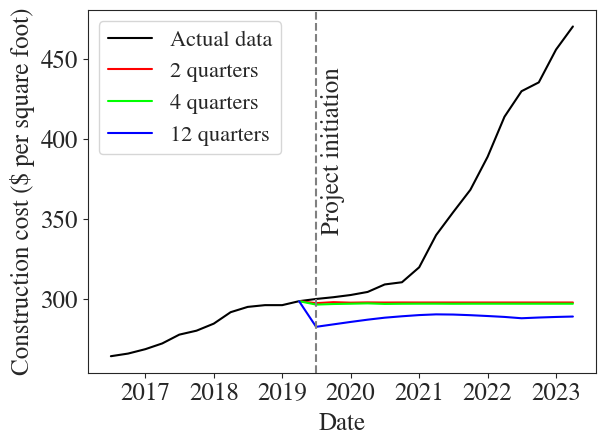

In [ ]:
# Mean model parameterization
results = expectation_formation('Scenarios_2_parameterization', [1, 2, 10, 18], 'cc',
                                construction_cost_data_df=construction_cost_data_df,
                                vacancy_data_df=vacancy_rates_data_df,
                                absorption_data_df=absorption_rate_data_df,
                                rent_data_df=rent_data_df,
                                sales_data_df=sales_data_df,
                                interest_rate_data_df=interest_rate_data_df,
                                cc_expectation=True)
results = results.rename({10:3, 18:4}, axis=1)
plot_line([1, 2, 3, 4], results, ['Actual data', '2 quarters', '4 quarters', '12 quarters'], 'Date', ylabel='Construction cost ($ per square foot)', legsize=16)
plt.axvline(x=datetime(2019, 7, 1), color='gray', linestyle='--')
plt.text(datetime(2019, 10, 1), 340, 'Project initiation', ha='center', va='bottom', rotation=90)

Scenario 1 completed . . .
Scenario 3 completed . . .
Scenario 11 completed . . .
Scenario 19 completed . . .


Text(2019-10-01 00:00:00, 340, 'Project initiation')

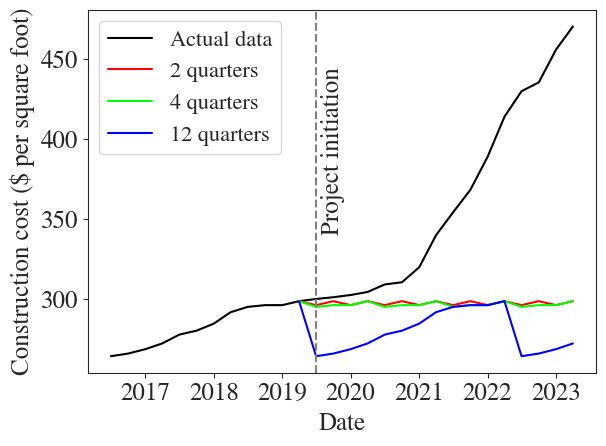

In [ ]:
# Cycle model parameterization
results = expectation_formation('Scenarios_2_parameterization', [1, 3, 11, 19], 'cc',
                                construction_cost_data_df=construction_cost_data_df,
                                vacancy_data_df=vacancy_rates_data_df,
                                absorption_data_df=absorption_rate_data_df,
                                rent_data_df=rent_data_df,
                                sales_data_df=sales_data_df,
                                interest_rate_data_df=interest_rate_data_df,
                                cc_expectation=True)
results = results.rename({3:2, 11:3, 19:4}, axis=1)
plot_line([1, 2, 3, 4], results, ['Actual data', '2 quarters', '4 quarters', '12 quarters'], 'Date', ylabel='Construction cost ($ per square foot)', legsize=16)
plt.axvline(x=datetime(2019, 7, 1), color='gray', linestyle='--')
plt.text(datetime(2019, 10, 1), 340, 'Project initiation', ha='center', va='bottom', rotation=90)

Scenario 1 completed . . .
Scenario 4 completed . . .
Scenario 12 completed . . .
Scenario 20 completed . . .


Text(2019-10-01 00:00:00, 340, 'Project initiation')

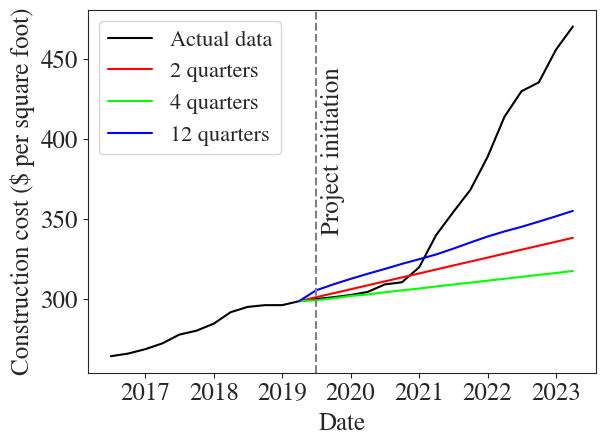

In [ ]:
# Projection model parameterization
results = expectation_formation('Scenarios_2_parameterization', [1, 4, 12, 20], 'cc',
                                construction_cost_data_df=construction_cost_data_df,
                                vacancy_data_df=vacancy_rates_data_df,
                                absorption_data_df=absorption_rate_data_df,
                                rent_data_df=rent_data_df,
                                sales_data_df=sales_data_df,
                                interest_rate_data_df=interest_rate_data_df,
                                cc_expectation=True)
results = results.rename({4:2, 12:3, 20:4}, axis=1)
plot_line([1, 2, 3, 4], results, ['Actual data', '2 quarters', '4 quarters', '12 quarters'], 'Date', ylabel='Construction cost ($ per square foot)', legsize=16)
plt.axvline(x=datetime(2019, 7, 1), color='gray', linestyle='--')
plt.text(datetime(2019, 10, 1), 340, 'Project initiation', ha='center', va='bottom', rotation=90)

Scenario 1 completed . . .
Scenario 5 completed . . .
Scenario 13 completed . . .
Scenario 21 completed . . .


Text(2019-10-01 00:00:00, 340, 'Project initiation')

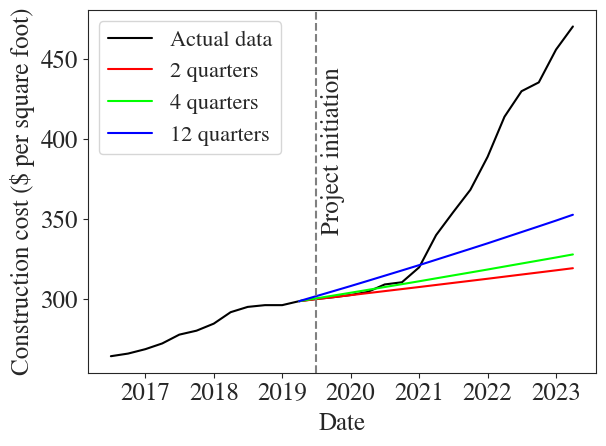

In [ ]:
# Re-scale model parameterization
results = expectation_formation('Scenarios_2_parameterization', [1, 5, 13, 21], 'cc',
                                construction_cost_data_df=construction_cost_data_df,
                                vacancy_data_df=vacancy_rates_data_df,
                                absorption_data_df=absorption_rate_data_df,
                                rent_data_df=rent_data_df,
                                sales_data_df=sales_data_df,
                                interest_rate_data_df=interest_rate_data_df,
                                cc_expectation=True)
results = results.rename({5:2, 13:3, 21:4}, axis=1)
plot_line([1, 2, 3, 4], results, ['Actual data', '2 quarters', '4 quarters', '12 quarters'], 'Date', ylabel='Construction cost ($ per square foot)', legsize=16)
plt.axvline(x=datetime(2019, 7, 1), color='gray', linestyle='--')
plt.text(datetime(2019, 10, 1), 340, 'Project initiation', ha='center', va='bottom', rotation=90)

In [ ]:
results = expectation_formation('Scenarios_2', scenarios, 'cc',
                                construction_cost_data_df=construction_cost_data_df,
                                vacancy_data_df=vacancy_rates_data_df,
                                absorption_data_df=absorption_rate_data_df,
                                rent_data_df=rent_data_df,
                                sales_data_df=sales_data_df,
                                interest_rate_data_df=interest_rate_data_df,
                                cc_expectation=True)

Scenario 1 completed . . .
Scenario 2 completed . . .
Scenario 3 completed . . .
Scenario 4 completed . . .
Scenario 5 completed . . .
Scenario 6 completed . . .
Scenario 7 completed . . .
Scenario 8 completed . . .
Scenario 9 completed . . .
Scenario 10 completed . . .
Scenario 11 completed . . .


In [ ]:
columns = [col for col in results.columns if col != 1] + [1]
results = results.reindex(columns=columns)
labels = labels[1:] + [labels[0]]
scenarios = scenarios[1:] + [scenarios[0]]

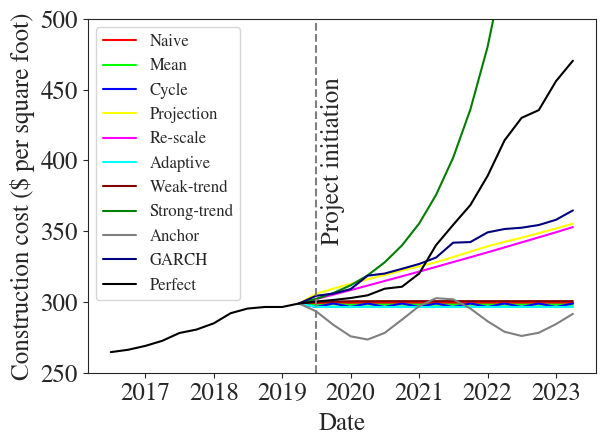

In [ ]:
plot_line(scenarios, results, labels, 'Date', ylabel='Construction cost ($ per square foot)', legsize=12, ylim=[250, 500])
plt.axvline(x=datetime(2019, 7, 1), color='gray', linestyle='--')
plt.text(datetime(2019, 10, 1), 340, 'Project initiation', ha='center', va='bottom', rotation=90)
plt.savefig('cc_all_expectations.png', dpi=300, bbox_inches='tight')

## 1.2 Sensitivity analysis

In [ ]:
expectation_factors = ['rp', 'i']
for factor in expectation_factors:
  for i in range(len(scenarios)):
    proforma_inputs_df[i+1]['{}_model'.format(factor)] = 'Actual'
test_proforma = proforma(proforma_inputs_df,
                         construction_cost_data_df=construction_cost_data_df, construction_cost_data_type='index', cc_price_base=295,
                         vacancy_data_df=vacancy_rates_data_df,
                         absorption_data_df=absorption_rate_data_df,
                         rent_data_df=rent_data_df,
                         sales_data_df=sales_data_df,
                         interest_rate_data_df=interest_rate_data_df)

In [ ]:
results = test_proforma.run(scenarios, cc_expectation=True, vr_expectation=False, rp_expectation=True, i_expectation=True)

In [ ]:
results = results[1:] + [results[0]]
labels = labels[1:] + [labels[0]]
scenarios = scenarios[1:] + [scenarios[0]]

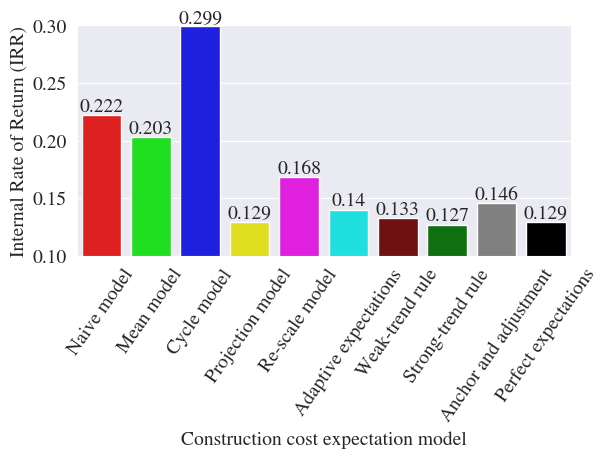

In [ ]:
plot_bar(results, labels, 'Construction cost expectation model', rotation=55, ylim=(0.1, 0.3))

In [ ]:
# Sensitivity to interest rate (i)
i_range = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16]
results = run_numerical_sensitivity('i', i_range, scenarios=scenarios,
                                    proforma_inputs_df=proforma_inputs_df,
                                    construction_cost_data_df=construction_cost_data_df,
                                    vacancy_data_df=vacancy_rates_data_df,
                                    absorption_data_df=absorption_rate_data_df,
                                    rent_data_df=rent_data_df,
                                    sales_data_df=sales_data_df,
                                    interest_rate_data_df=interest_rate_data_df,
                                    cc_expectation=True, vr_expectation=False, rp_expectation=True, i_expectation=False)

In [ ]:
column_order = [col for col in results.columns if col != 1] + [1]
results = results.reindex(columns=column_order)
labels = labels[1:] + [labels[0]]
scenarios = scenarios[1:] + [scenarios[0]]

Text(0.035, 0.03, 'i = 2.88%')

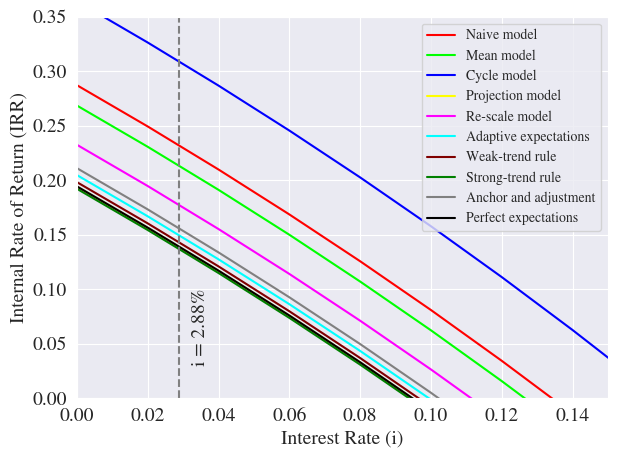

In [ ]:
plot_line(scenarios, results, labels, 'Interest Rate (i)', xlim=[0, 0.15], legsize=10, ylim=[0, 0.35])
plt.axvline(x=0.0288, color='gray', linestyle='--')
plt.text(0.035, 0.03, 'i = 2.88%', ha='center', va='bottom', rotation=90)

In [ ]:
# Sensitivity to unit sales price (pi)
i_range = [600000, 650000, 700000, 750000, 800000, 850000, 900000, 950000, 1000000, 1050000, 1100000]
results = run_numerical_sensitivity('pi', i_range, scenarios=scenarios,
                                    proforma_inputs_df=proforma_inputs_df,
                                    construction_cost_data_df=construction_cost_data_df,
                                    vacancy_data_df=vacancy_rates_data_df,
                                    absorption_data_df=absorption_rate_data_df,
                                    rent_data_df=rent_data_df,
                                    sales_data_df=sales_data_df,
                                    interest_rate_data_df=interest_rate_data_df,
                                    cc_expectation=True, vr_expectation=False, rp_expectation=False, i_expectation=True)

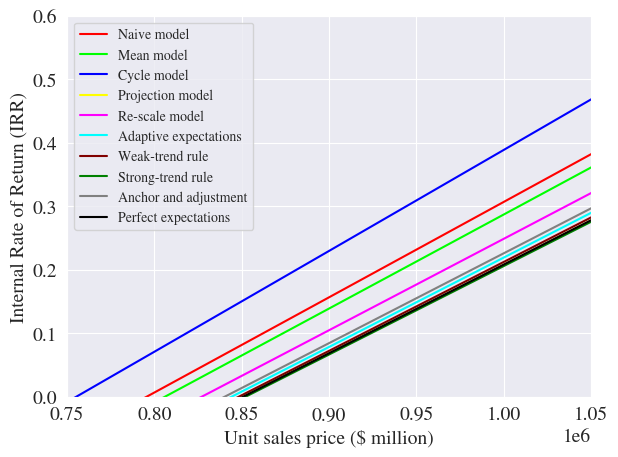

In [ ]:
plot_line(scenarios, results, labels, 'Unit sales price ($ million)', xlim=[750000, 1050000], ylim=(0, 0.6), legsize=10)

# 2 Sales price expectations

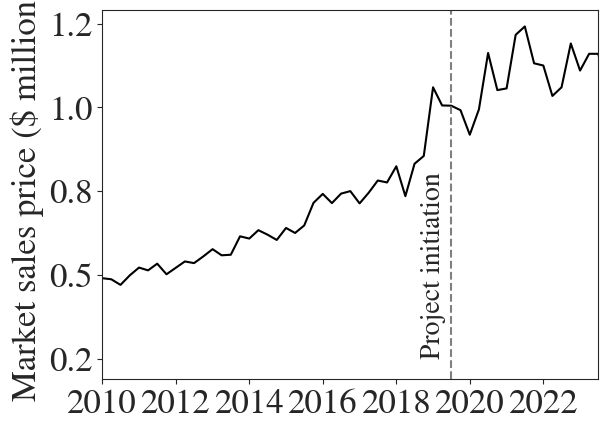

In [ ]:
plt.plot(sales_data_df['REF_DATE'], sales_data_df['Average'], color='black')
plt.xlim(datetime(2010, 1, 1), datetime(2023, 7, 1))
plt.gca().set_ylabel('Market sales price ($ million)')
plt.axvline(x=datetime(2019, 7, 1), color='gray', linestyle='--')
plt.text(datetime(2019, 1, 1), 250000, 'Project initiation', ha='center', va='bottom', rotation=90, size=20)
def custom_format(x, pos):
    return f'{x/1e6:.1f}'

# Set the custom formatter for the y-axis
formatter = mticker.FuncFormatter(custom_format)
plt.gca().yaxis.set_major_formatter(formatter)
plt.savefig('rp_hist.png', dpi=300, bbox_inches='tight')

In [ ]:
# Setup a test proforma to be used for different experiments with the unit sales price expectation mechanisms
test_proforma = proforma(proforma_inputs_df,
                         construction_cost_data_df=construction_cost_data_df, construction_cost_data_type='index', cc_price_base=275,
                         vacancy_data_df=vacancy_rates_data_df,
                         absorption_data_df=absorption_rate_data_df,
                         rent_data_df=rent_data_df,
                         sales_data_df=sales_data_df,
                         interest_rate_data_df=interest_rate_data_df)

## 3.1 Parameterization

In [ ]:
rp_rescale_factors = []
# Parameterization of the re-scale model
start_index_init = 107
end_index_init = 119
for i in range(16):
  observation = sales_data_df[['REF_DATE', 'Average']][start_index_init+i:end_index_init+i]
  step = []
  for j in range(start_index_init+i, end_index_init+i):
    step.append(sales_data_df['Average'][j] / sales_data_df['Average'][j-1])
  observation['step'] = step
  rp_rescale_factors.append(observation['step'].mean())

In [ ]:
observation = sales_data_df[['REF_DATE', 'Average']][start_index_init:end_index_init]
step = []
for j in range(start_index_init, end_index_init):
  step.append(sales_data_df['Average'][j] / sales_data_df['Average'][j-1])
observation['step'] = step
print('rescale factor for 12 periods: ', observation['step'].mean())
print('rescale factor for 4 periods: ', observation[8:]['step'].mean())
print('rescale factor for 2 periods: ', observation[10:]['step'].mean())

rescale factor for 12 periods:  1.0290733176687248
rescale factor for 4 periods:  1.0539732661876815
rescale factor for 2 periods:  0.9740354353274661


Scenario 1 completed . . .
Scenario 2 completed . . .
Scenario 10 completed . . .
Scenario 18 completed . . .


Text(2019-10-01 00:00:00, 1250000, 'Project initiation')

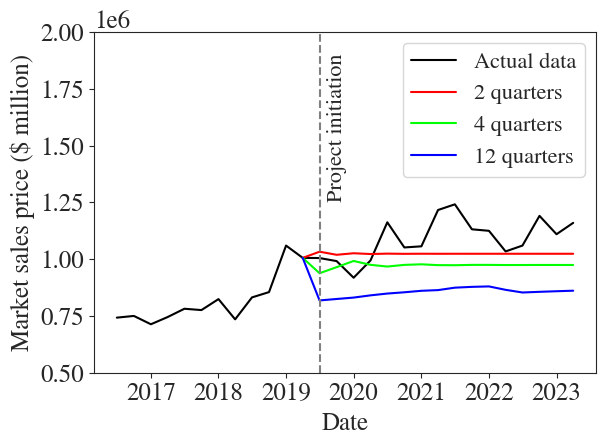

In [ ]:
# Mean model parameterization
results = expectation_formation('Scenarios_2_parameterization', [1, 2, 10, 18], 'rp',
                                construction_cost_data_df=construction_cost_data_df,
                                vacancy_data_df=vacancy_rates_data_df,
                                absorption_data_df=absorption_rate_data_df,
                                rent_data_df=rent_data_df,
                                sales_data_df=sales_data_df,
                                interest_rate_data_df=interest_rate_data_df,
                                rp_expectation=True)
results = results.rename({10:3, 18:4}, axis=1)
plot_line([1, 2, 3, 4], results, ['Actual data', '2 quarters', '4 quarters', '12 quarters'], 'Date', ylabel='Market sales price ($ million)', legsize=16, ylim=[500000, 2000000])
plt.axvline(x=datetime(2019, 7, 1), color='gray', linestyle='--')
plt.text(datetime(2019, 10, 1), 1250000, 'Project initiation', ha='center', va='bottom', rotation=90, fontsize=16)

Scenario 1 completed . . .
Scenario 3 completed . . .
Scenario 11 completed . . .
Scenario 19 completed . . .


Text(2019-10-01 00:00:00, 1270000, 'Project initiation')

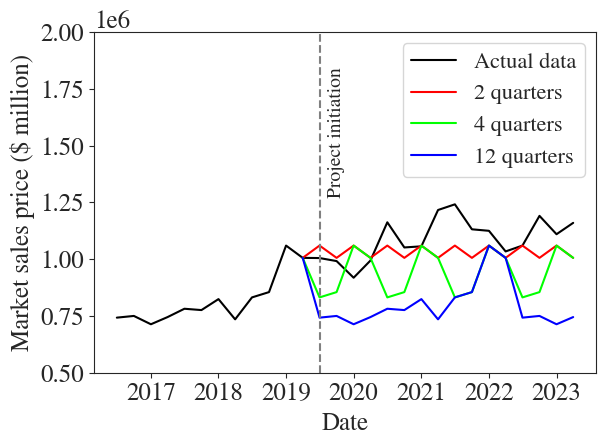

In [ ]:
# Cycle model parameterization
results = expectation_formation('Scenarios_2_parameterization', [1, 3, 11, 19], 'rp',
                                construction_cost_data_df=construction_cost_data_df,
                                vacancy_data_df=vacancy_rates_data_df,
                                absorption_data_df=absorption_rate_data_df,
                                rent_data_df=rent_data_df,
                                sales_data_df=sales_data_df,
                                interest_rate_data_df=interest_rate_data_df,
                                rp_expectation=True)
results = results.rename({3:2, 11:3, 19:4}, axis=1)
plot_line([1, 2, 3, 4], results, ['Actual data', '2 quarters', '4 quarters', '12 quarters'], 'Date', ylabel='Market sales price ($ million)', legsize=16, ylim=[500000, 2000000])
plt.axvline(x=datetime(2019, 7, 1), color='gray', linestyle='--')
plt.text(datetime(2019, 10, 1), 1270000, 'Project initiation', ha='center', va='bottom', rotation=90, fontsize=14)

Scenario 1 completed . . .
Scenario 4 completed . . .
Scenario 12 completed . . .
Scenario 20 completed . . .


Text(2019-10-01 00:00:00, 1270000, 'Project initiation')

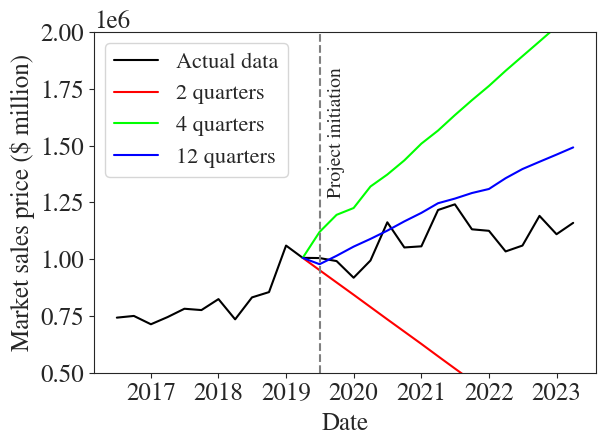

In [ ]:
# Projection model parameterization
results = expectation_formation('Scenarios_2_parameterization', [1, 4, 12, 20], 'rp',
                                construction_cost_data_df=construction_cost_data_df,
                                vacancy_data_df=vacancy_rates_data_df,
                                absorption_data_df=absorption_rate_data_df,
                                rent_data_df=rent_data_df,
                                sales_data_df=sales_data_df,
                                interest_rate_data_df=interest_rate_data_df,
                                rp_expectation=True)
results = results.rename({4:2, 12:3, 20:4}, axis=1)
plot_line([1, 2, 3, 4], results, ['Actual data', '2 quarters', '4 quarters', '12 quarters'], 'Date', ylabel='Market sales price ($ million)', legsize=16, ylim=[500000, 2000000])
plt.axvline(x=datetime(2019, 7, 1), color='gray', linestyle='--')
plt.text(datetime(2019, 10, 1), 1270000, 'Project initiation', ha='center', va='bottom', rotation=90, fontsize=14)

Scenario 1 completed . . .
Scenario 5 completed . . .
Scenario 13 completed . . .
Scenario 21 completed . . .


Text(2019-10-01 00:00:00, 1070000, 'Project initiation')

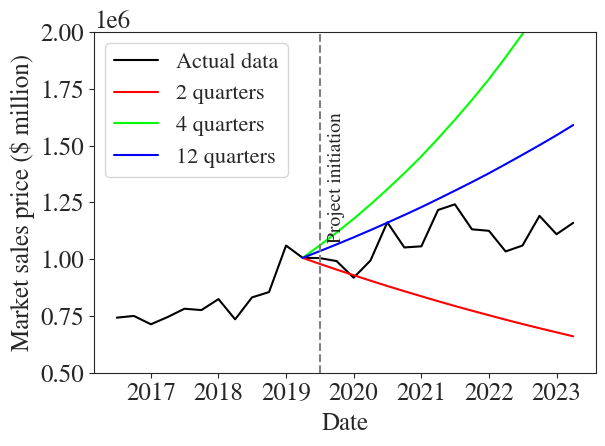

In [ ]:
# Re-scale model parameterization
results = expectation_formation('Scenarios_2_parameterization', [1, 5, 13, 21], 'rp',
                                construction_cost_data_df=construction_cost_data_df,
                                vacancy_data_df=vacancy_rates_data_df,
                                absorption_data_df=absorption_rate_data_df,
                                rent_data_df=rent_data_df,
                                sales_data_df=sales_data_df,
                                interest_rate_data_df=interest_rate_data_df,
                                rp_expectation=True)
results = results.rename({5:2, 13:3, 21:4}, axis=1)
plot_line([1, 2, 3, 4], results, ['Actual data', '2 quarters', '4 quarters', '12 quarters'], 'Date', ylabel='Market sales price ($ million)', legsize=16, ylim=[500000, 2000000])
plt.axvline(x=datetime(2019, 7, 1), color='gray', linestyle='--')
plt.text(datetime(2019, 10, 1), 1070000, 'Project initiation', ha='center', va='bottom', rotation=90, fontsize=14)

In [ ]:
scenarios = proforma_inputs_df.columns.to_list()[2:13]
labels = ['Perfect', 'Naive', 'Mean', 'Cycle', 'Projection', 'Re-scale', 'Adaptive', 'Weak-trend', 'Strong-trend', 'Anchor', 'GARCH']
results = expectation_formation('Scenarios_2', scenarios, 'rp',
                                construction_cost_data_df=construction_cost_data_df,
                                vacancy_data_df=vacancy_rates_data_df,
                                absorption_data_df=absorption_rate_data_df,
                                rent_data_df=rent_data_df,
                                sales_data_df=sales_data_df,
                                interest_rate_data_df=interest_rate_data_df,
                                rp_expectation=True)

Scenario 1 completed . . .
Scenario 2 completed . . .
Scenario 3 completed . . .
Scenario 4 completed . . .
Scenario 5 completed . . .
Scenario 6 completed . . .
Scenario 7 completed . . .
Scenario 8 completed . . .
Scenario 9 completed . . .
Scenario 10 completed . . .
Scenario 11 completed . . .


In [ ]:
columns = [col for col in results.columns if col != 1] + [1]
results = results.reindex(columns=columns)
labels = labels[1:] + [labels[0]]
scenarios = scenarios[1:] + [scenarios[0]]

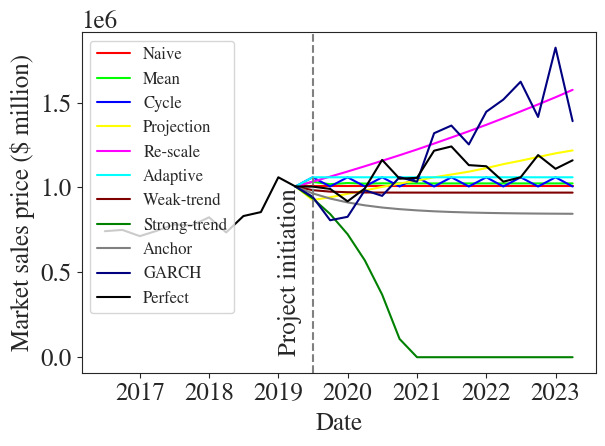

In [ ]:
plot_line(scenarios, results, labels, 'Date', ylabel='Market sales price ($ million)', legsize=12)
plt.axvline(x=datetime(2019, 7, 1), color='gray', linestyle='--')
plt.text(datetime(2019, 3, 1), 10000, 'Project initiation', ha='center', va='bottom', rotation=90, fontsize=18)
plt.savefig('rp_all_expectations.png', dpi=300, bbox_inches='tight')

## 3.2 Sensitivity analysis

In [ ]:
expectation_factors = ['cc', 'i']
for factor in expectation_factors:
  for i in range(len(scenarios)):
    proforma_inputs_df[i+1]['{}_model'.format(factor)] = 'Actual'
test_proforma = proforma(proforma_inputs_df,
                         construction_cost_data_df=construction_cost_data_df, construction_cost_data_type='index', cc_price_base=295,
                         vacancy_data_df=vacancy_rates_data_df,
                         absorption_data_df=absorption_rate_data_df,
                         rent_data_df=rent_data_df,
                         sales_data_df=sales_data_df,
                         interest_rate_data_df=interest_rate_data_df)

In [ ]:
results = test_proforma.run(scenarios, cc_expectation=True, vr_expectation=False, rp_expectation=True, i_expectation=True)

In [ ]:
results = results[1:] + [results[0]]
labels = labels[1:] + [labels[0]]
scenarios = scenarios[1:] + [scenarios[0]]

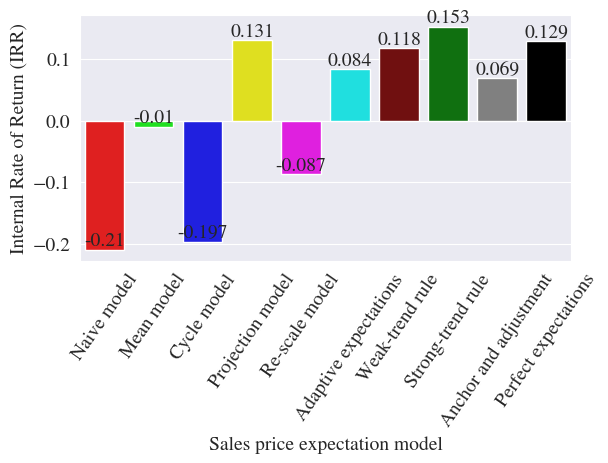

In [ ]:
plot_bar(results, labels, 'Sales price expectation model', rotation=55)

In [ ]:
# Sensitivity to interest rate (i)
i_range = [0.01, 0.02, 0.03, 0.04, 0.05]
results = run_numerical_sensitivity('i', i_range, sheet_name='Scenarios_2', scenarios=scenarios,
                                    construction_cost_data_df=construction_cost_data_df,
                                    vacancy_data_df=vacancy_rates_data_df,
                                    absorption_data_df=absorption_rate_data_df,
                                    rent_data_df=rent_data_df,
                                    sales_data_df=sales_data_df,
                                    rp_expectation=True)

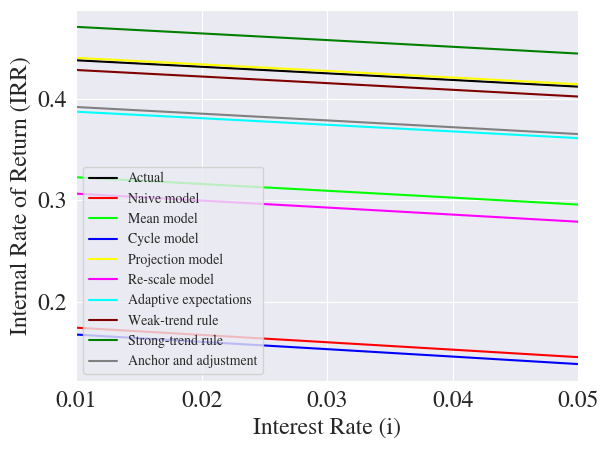

In [ ]:
plot_line(scenarios, results, labels, 'Interest Rate (i)', xlim=[0.01, 0.05], legsize=10)

In [ ]:
# Sensitivity to construction costs (tau)
i_range = [230, 240, 250, 260, 270]
results = run_numerical_sensitivity('tau', i_range, sheet_name='Scenarios_2', scenarios=scenarios,
                                    construction_cost_data_df=construction_cost_data_df,
                                    vacancy_data_df=vacancy_rates_data_df,
                                    absorption_data_df=absorption_rate_data_df,
                                    rent_data_df=rent_data_df,
                                    sales_data_df=sales_data_df,
                                    rp_expectation=True)

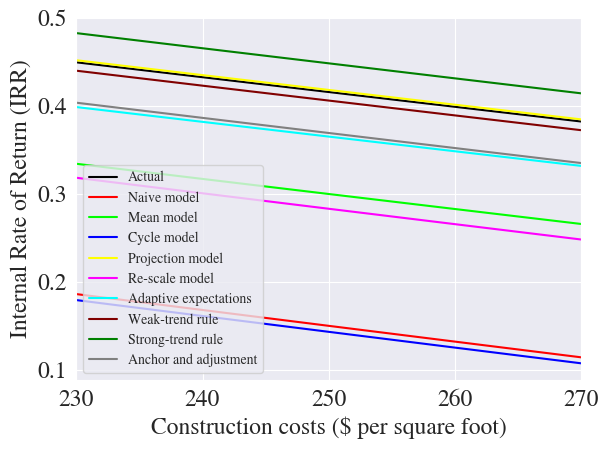

In [ ]:
plot_line(scenarios, results, labels, 'Construction costs ($ per square foot)', xlim=[230, 270], legsize=10)

# 3 Interest rate expectation

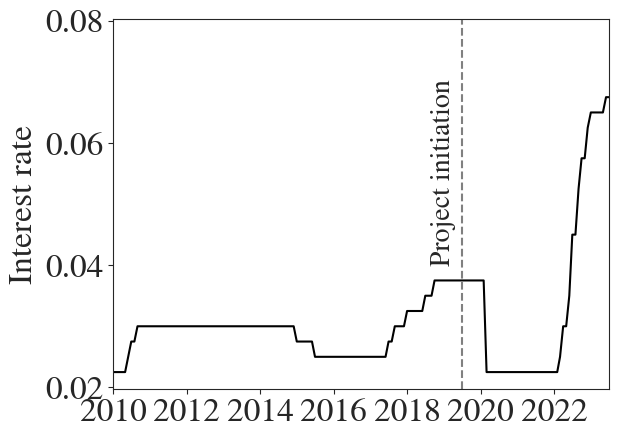

In [ ]:
plt.plot(interest_rate_data_df['REF_DATE'], interest_rate_data_df['Interest rate'], color='black')
plt.xlim(datetime(2010, 1, 1), datetime(2023, 7, 1))
plt.gca().set_ylabel('Interest rate')
plt.axvline(x=datetime(2019, 7, 1), color='gray', linestyle='--')
plt.text(datetime(2019, 1, 1), 0.04, 'Project initiation', ha='center', va='bottom', rotation=90, size=20)
plt.savefig('i_hist.png', dpi=300, bbox_inches='tight')

In [ ]:
# Setup a test proforma to be used for different experiments with the interest rate expectation mechanisms
test_proforma = proforma(proforma_inputs_df,
                         construction_cost_data_df=construction_cost_data_df, construction_cost_data_type='index', cc_price_base=205,
                         vacancy_data_df=vacancy_rates_data_df,
                         absorption_data_df=absorption_rate_data_df,
                         rent_data_df=rent_data_df,
                         sales_data_df=sales_data_df,
                         interest_rate_data_df=interest_rate_data_df)

## 4.1 Parameterization

In [ ]:
i_rescale_factors = []
# Parameterization of the re-scale model
start_index_init = 197
end_index_init = 233
for i in range(16):
  observation = interest_rate_data_df[['REF_DATE', 'Interest rate']][start_index_init+3*i:end_index_init+3*i]
  step = []
  for j in range(start_index_init+3*i, end_index_init+3*i):
    step.append(interest_rate_data_df['Interest rate'][j] / interest_rate_data_df['Interest rate'][j-1])
  observation['step'] = step
  i_rescale_factors.append(observation[28:]['step'].mean())

In [ ]:
observation = interest_rate_data_df[['REF_DATE', 'Interest rate']][start_index_init:end_index_init]
step = []
for j in range(start_index_init, end_index_init):
  step.append(interest_rate_data_df['Interest rate'][j] / interest_rate_data_df['Interest rate'][j-1])
observation['step'] = step
print('rescale factor for 36 periods: ', observation['step'].mean())
print('rescale factor for 12 periods: ', observation[24:]['step'].mean())
print('rescale factor for 6 periods: ', observation[30:]['step'].mean())

rescale factor for 36 periods:  1.0117387242387241
rescale factor for 12 periods:  1.0123626373626373
rescale factor for 6 periods:  1.0


Scenario 1 completed . . .
Scenario 2 completed . . .
Scenario 10 completed . . .
Scenario 18 completed . . .


Text(2019-10-01 00:00:00, 0.045, 'Project initiation')

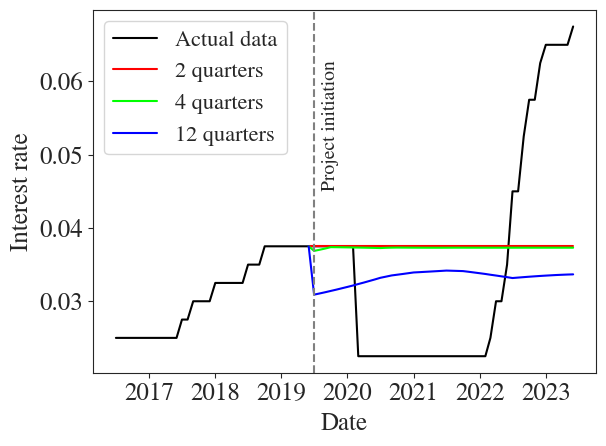

In [ ]:
# Mean model parameterization
results = expectation_formation('Scenarios_2_parameterization', [1, 2, 10, 18], 'i',
                                construction_cost_data_df=construction_cost_data_df,
                                vacancy_data_df=vacancy_rates_data_df,
                                absorption_data_df=absorption_rate_data_df,
                                rent_data_df=rent_data_df,
                                sales_data_df=sales_data_df,
                                interest_rate_data_df=interest_rate_data_df,
                                i_expectation=True)
results = results.rename({10:3, 18:4}, axis=1)
plot_line([1, 2, 3, 4], results, ['Actual data', '2 quarters', '4 quarters', '12 quarters'], 'Date', ylabel='Interest rate', legsize=16)
plt.axvline(x=datetime(2019, 7, 1), color='gray', linestyle='--')
plt.text(datetime(2019, 10, 1), 0.045, 'Project initiation', ha='center', va='bottom', rotation=90, fontsize=14)

Scenario 1 completed . . .
Scenario 3 completed . . .
Scenario 11 completed . . .
Scenario 19 completed . . .


Text(2019-10-01 00:00:00, 0.045, 'Project initiation')

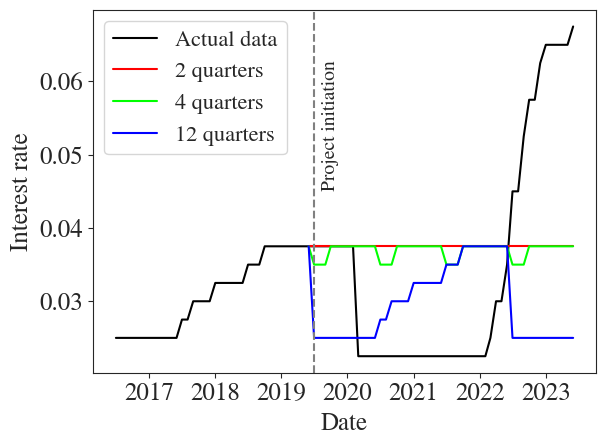

In [ ]:
# Cycle model parameterization
results = expectation_formation('Scenarios_2_parameterization', [1, 3, 11, 19], 'i',
                                construction_cost_data_df=construction_cost_data_df,
                                vacancy_data_df=vacancy_rates_data_df,
                                absorption_data_df=absorption_rate_data_df,
                                rent_data_df=rent_data_df,
                                sales_data_df=sales_data_df,
                                interest_rate_data_df=interest_rate_data_df,
                                i_expectation=True)
results = results.rename({3:2, 11:3, 19:4}, axis=1)
plot_line([1, 2, 3, 4], results, ['Actual data', '2 quarters', '4 quarters', '12 quarters'], 'Date', ylabel='Interest rate', legsize=16)
plt.axvline(x=datetime(2019, 7, 1), color='gray', linestyle='--')
plt.text(datetime(2019, 10, 1), 0.045, 'Project initiation', ha='center', va='bottom', rotation=90, fontsize=14)

Scenario 1 completed . . .
Scenario 4 completed . . .
Scenario 12 completed . . .
Scenario 20 completed . . .


Text(2019-10-01 00:00:00, 0.045, 'Project initiation')

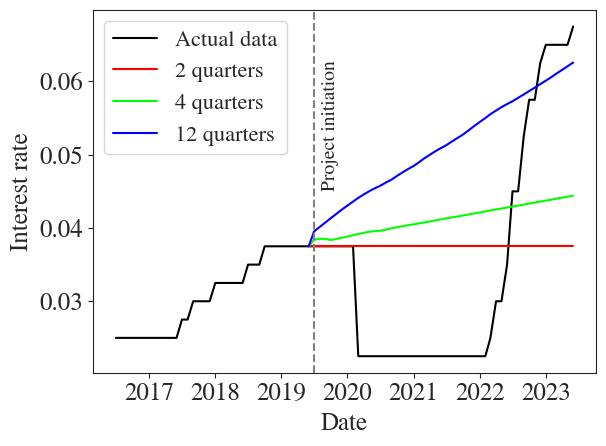

In [ ]:
# Projection model parameterization
results = expectation_formation('Scenarios_2_parameterization', [1, 4, 12, 20], 'i',
                                construction_cost_data_df=construction_cost_data_df,
                                vacancy_data_df=vacancy_rates_data_df,
                                absorption_data_df=absorption_rate_data_df,
                                rent_data_df=rent_data_df,
                                sales_data_df=sales_data_df,
                                interest_rate_data_df=interest_rate_data_df,
                                i_expectation=True)
results = results.rename({4:2, 12:3, 20:4}, axis=1)
plot_line([1, 2, 3, 4], results, ['Actual data', '2 quarters', '4 quarters', '12 quarters'], 'Date', ylabel='Interest rate', legsize=16)
plt.axvline(x=datetime(2019, 7, 1), color='gray', linestyle='--')
plt.text(datetime(2019, 10, 1), 0.045, 'Project initiation', ha='center', va='bottom', rotation=90, fontsize=14)

Scenario 1 completed . . .
Scenario 5 completed . . .
Scenario 13 completed . . .
Scenario 21 completed . . .


Text(2019-10-01 00:00:00, 0.045, 'Project initiation')

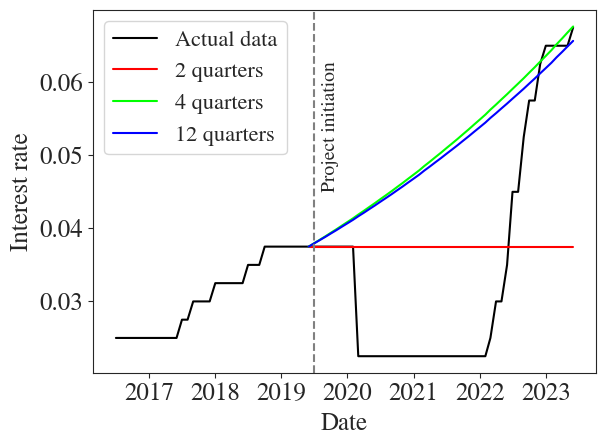

In [ ]:
# Re-scale model parameterization
results = expectation_formation('Scenarios_2_parameterization', [1, 5, 13, 21], 'i',
                                construction_cost_data_df=construction_cost_data_df,
                                vacancy_data_df=vacancy_rates_data_df,
                                absorption_data_df=absorption_rate_data_df,
                                rent_data_df=rent_data_df,
                                sales_data_df=sales_data_df,
                                interest_rate_data_df=interest_rate_data_df,
                                i_expectation=True)
results = results.rename({5:2, 13:3, 21:4}, axis=1)
plot_line([1, 2, 3, 4], results, ['Actual data', '2 quarters', '4 quarters', '12 quarters'], 'Date', ylabel='Interest rate', legsize=16)
plt.axvline(x=datetime(2019, 7, 1), color='gray', linestyle='--')
plt.text(datetime(2019, 10, 1), 0.045, 'Project initiation', ha='center', va='bottom', rotation=90, fontsize=14)

In [ ]:
scenarios = proforma_inputs_df.columns.to_list()[2:13]
labels = ['Perfect', 'Naive', 'Mean', 'Cycle', 'Projection', 'Re-scale', 'Adaptive', 'Weak-trend', 'Strong-trend', 'Anchor', 'GARCH']
results = expectation_formation('Scenarios_2', scenarios, 'i',
                                construction_cost_data_df=construction_cost_data_df,
                                vacancy_data_df=vacancy_rates_data_df,
                                absorption_data_df=absorption_rate_data_df,
                                rent_data_df=rent_data_df,
                                sales_data_df=sales_data_df,
                                interest_rate_data_df=interest_rate_data_df,
                                i_expectation=True)

Scenario 1 completed . . .
Scenario 2 completed . . .
Scenario 3 completed . . .
Scenario 4 completed . . .
Scenario 5 completed . . .
Scenario 6 completed . . .
Scenario 7 completed . . .
Scenario 8 completed . . .
Scenario 9 completed . . .
Scenario 10 completed . . .
Scenario 11 completed . . .


In [ ]:
columns = [col for col in results.columns if col != 1] + [1]
results = results.reindex(columns=columns)
labels = labels[1:] + [labels[0]]
scenarios = scenarios[1:] + [scenarios[0]]

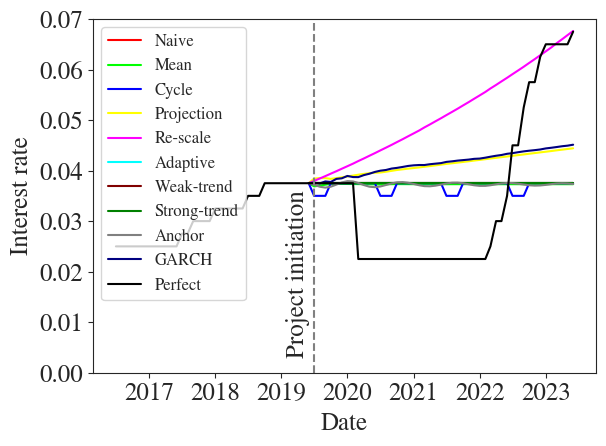

In [ ]:
plot_line(scenarios, results, labels, 'Date', ylabel='Interest rate', legsize=12, ylim=[0, 0.07])
plt.axvline(x=datetime(2019, 7, 1), color='gray', linestyle='--')
plt.text(datetime(2019, 4, 1), 0.003, 'Project initiation', ha='center', va='bottom', rotation=90, fontsize=18)
plt.savefig('i_all_expectations.png', dpi=300, bbox_inches='tight')

## 4.2 Sensitivity analysis

In [ ]:
expectation_factors = ['cc', 'rp']
for factor in expectation_factors:
  for i in range(len(scenarios)):
    proforma_inputs_df[i+1]['{}_model'.format(factor)] = 'Actual'
test_proforma = proforma(proforma_inputs_df,
                         construction_cost_data_df=construction_cost_data_df, construction_cost_data_type='index', cc_price_base=295,
                         vacancy_data_df=vacancy_rates_data_df,
                         absorption_data_df=absorption_rate_data_df,
                         rent_data_df=rent_data_df,
                         sales_data_df=sales_data_df,
                         interest_rate_data_df=interest_rate_data_df)

In [ ]:
results = test_proforma.run(scenarios, cc_expectation=True, vr_expectation=False, rp_expectation=True, i_expectation=True)

In [ ]:
results = results[1:] + [results[0]]
labels = labels[1:] + [labels[0]]
scenarios = scenarios[1:] + [scenarios[0]]

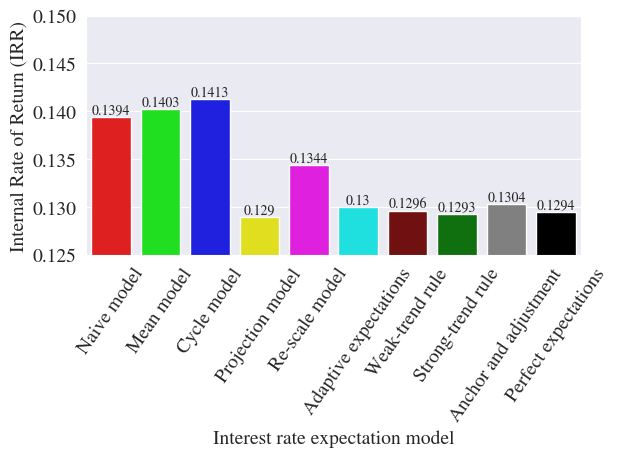

In [ ]:
plot_bar(results, labels, 'Interest rate expectation model', ylim=(0.125, 0.15), rotation=55)

In [ ]:
# Sensitivity to construction costs (tau)
tau_range = [240, 260, 280, 300, 320, 340]
results = run_numerical_sensitivity('tau', tau_range, scenarios=scenarios,
                                    proforma_inputs_df=proforma_inputs_df,
                                    construction_cost_data_df=construction_cost_data_df,
                                    vacancy_data_df=vacancy_rates_data_df,
                                    absorption_data_df=absorption_rate_data_df,
                                    rent_data_df=rent_data_df,
                                    sales_data_df=sales_data_df,
                                    interest_rate_data_df=interest_rate_data_df,
                                    cc_expectation=False, vr_expectation=False, rp_expectation=True, i_expectation=True)

In [ ]:
column_order = [col for col in results.columns if col != 1] + [1]
results = results.reindex(columns=column_order)
labels = labels[1:] + [labels[0]]
scenarios = scenarios[1:] + [scenarios[0]]

Text(282, 0.1, 'τ = 285.56')

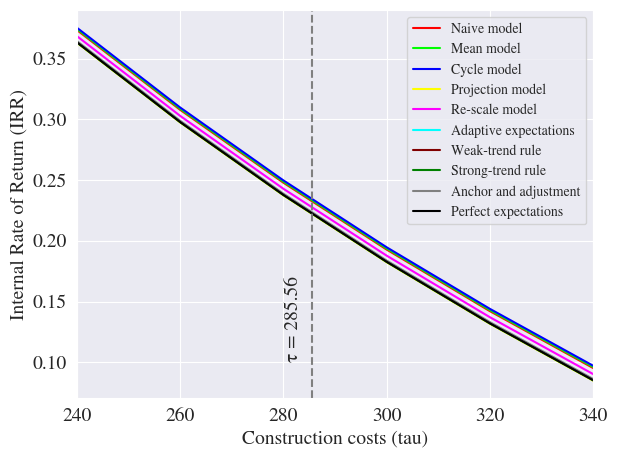

In [ ]:
plot_line(scenarios, results, labels, 'Construction costs (tau)', xlim=[240, 340], legsize=10)
plt.axvline(x=285.56, color='gray', linestyle='--')
plt.text(282, 0.1, '\u03C4 = 285.56', ha='center', va='bottom', rotation=90)

Text(284, 0.16, 'τ = 285.56')

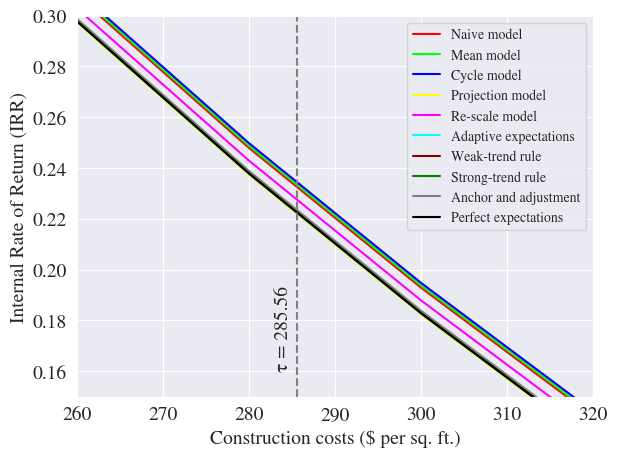

In [ ]:
plot_line(scenarios, results, labels, 'Construction costs ($ per sq. ft.)', xlim=[260, 320], legsize=10, ylim=[0.15, 0.3])
plt.axvline(x=285.56, color='gray', linestyle='--')
plt.text(284, 0.16, '\u03C4 = 285.56', ha='center', va='bottom', rotation=90)

In [ ]:
# Sensitivity to market absorption rate (tau)
omega_range = [0, 0.2, 0.4, 0.6, 0.8, 0.933, 1]
results = run_numerical_sensitivity('omega', omega_range, sheet_name='Scenarios_2', scenarios=scenarios,
                                    construction_cost_data_df=construction_cost_data_df,
                                    vacancy_data_df=vacancy_rates_data_df,
                                    absorption_data_df=absorption_rate_data_df,
                                    rent_data_df=rent_data_df,
                                    sales_data_df=sales_data_df,
                                    interest_rate_data_df=interest_rate_data_df,
                                    i_expectation=True)

Text(0.94, 0.02, 'ω = 93.3%')

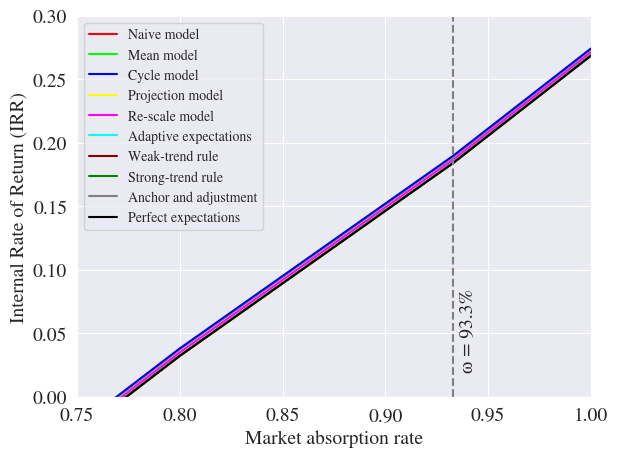

In [ ]:
plot_line(scenarios, results, labels, 'Market absorption rate', xlim=[0.75, 1], legsize=10, ylim=[0, 0.3])
plt.axvline(x=0.933, color='gray', linestyle='--')
plt.text(0.94, 0.02, '\u03C9 = 93.3%', ha='center', va='bottom', rotation=90)

Text(0.9325, 0.1897, 'ω = 93.3%')

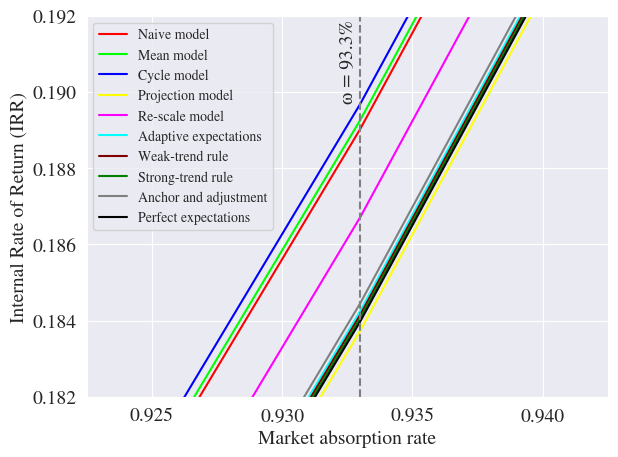

In [ ]:
plot_line(scenarios, results, labels, 'Market absorption rate', xlim=[0.9225, 0.9425], legsize=10, ylim=[0.182, 0.192])
plt.axvline(x=0.933, color='gray', linestyle='--')
plt.text(0.9325, 0.1897, '\u03C9 = 93.3%', ha='center', va='bottom', rotation=90)

In [ ]:
# Sensitivity to unit sales price (pi)
pi_range = [600000, 650000, 700000, 750000, 800000, 850000, 900000, 950000, 1000000, 1050000, 1100000]
results = run_numerical_sensitivity('pi', pi_range, scenarios=scenarios,
                                    proforma_inputs_df=proforma_inputs_df,
                                    construction_cost_data_df=construction_cost_data_df,
                                    vacancy_data_df=vacancy_rates_data_df,
                                    absorption_data_df=absorption_rate_data_df,
                                    rent_data_df=rent_data_df,
                                    sales_data_df=sales_data_df,
                                    interest_rate_data_df=interest_rate_data_df,
                                    cc_expectation=True, rp_expectation=False, vr_expectation=False, i_expectation=True)

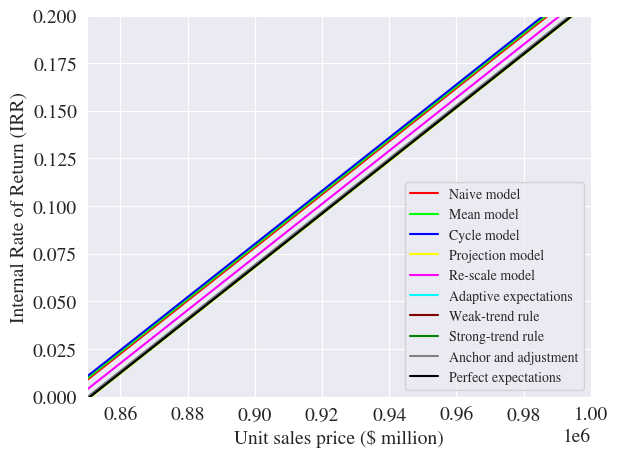

In [ ]:
plot_line(scenarios, results, labels, 'Unit sales price ($ million)', xlim=[850000, 1000000], legsize=10, ylim=[0, 0.2])
# plt.axvline(x=700000, color='gray', linestyle='--')
# plt.text(960332, 0.25, '\u03C0 = $944,332', ha='center', va='bottom', rotation=90)

In [ ]:
param_cc_results = expectation_formation('Scenarios_2_parameterization', [i for i in range(1, 26)], 'cc',
                                          construction_cost_data_df=construction_cost_data_df,
                                          vacancy_data_df=vacancy_rates_data_df,
                                          absorption_data_df=absorption_rate_data_df,
                                          rent_data_df=rent_data_df,
                                          sales_data_df=sales_data_df,
                                          interest_rate_data_df=interest_rate_data_df,
                                          cc_expectation=True)
mses_cc = []
for i in range(2, 26):
  mses_cc.append(mean_squared_error(param_cc_results[1].loc['2019-07':], param_cc_results[i].loc['2019-07':]))
mses_cc

Scenario 1 completed . . .
Scenario 2 completed . . .
Scenario 3 completed . . .
Scenario 4 completed . . .
Scenario 5 completed . . .
Scenario 6 completed . . .
Scenario 7 completed . . .
Scenario 8 completed . . .
Scenario 9 completed . . .
Scenario 10 completed . . .
Scenario 11 completed . . .
Scenario 12 completed . . .
Scenario 13 completed . . .
Scenario 14 completed . . .
Scenario 15 completed . . .
Scenario 16 completed . . .
Scenario 17 completed . . .
Scenario 18 completed . . .
Scenario 19 completed . . .
Scenario 20 completed . . .
Scenario 21 completed . . .
Scenario 22 completed . . .
Scenario 23 completed . . .
Scenario 24 completed . . .
Scenario 25 completed . . .


[7720.754809186457,
 7763.0114160156245,
 4185.306103515597,
 5696.846837383357,
 7937.5917285156265,
 7405.631701057864,
 35693.34389076354,
 6740.997343312524,
 7821.473221920544,
 7861.7398535156235,
 5850.642405641702,
 4991.493151499569,
 7955.547427093751,
 7405.631701057864,
 35693.34389076354,
 7532.230246024189,
 8973.269458624833,
 10689.339697265626,
 3049.4662578068032,
 3261.003419423012,
 7993.114407936027,
 7405.631701057864,
 35693.34389076354,
 9531.72899365928]

In [ ]:
param_rp_results = expectation_formation('Scenarios_2_parameterization', [i for i in range(1, 26)], 'rp',
                                          construction_cost_data_df=construction_cost_data_df,
                                          vacancy_data_df=vacancy_rates_data_df,
                                          absorption_data_df=absorption_rate_data_df,
                                          rent_data_df=rent_data_df,
                                          sales_data_df=sales_data_df,
                                          interest_rate_data_df=interest_rate_data_df,
                                          rp_expectation=True)
mses_rp = []
for i in range(2, 26):
  mses_rp.append(mean_squared_error(param_rp_results[1].loc['2019-07':], param_rp_results[i].loc['2019-07':]))
mses_rp

Scenario 1 completed . . .
Scenario 2 completed . . .
Scenario 3 completed . . .
Scenario 4 completed . . .
Scenario 5 completed . . .
Scenario 6 completed . . .
Scenario 7 completed . . .
Scenario 8 completed . . .
Scenario 9 completed . . .
Scenario 10 completed . . .
Scenario 11 completed . . .
Scenario 12 completed . . .
Scenario 13 completed . . .
Scenario 14 completed . . .
Scenario 15 completed . . .
Scenario 16 completed . . .
Scenario 17 completed . . .
Scenario 18 completed . . .
Scenario 19 completed . . .
Scenario 20 completed . . .
Scenario 21 completed . . .
Scenario 22 completed . . .
Scenario 23 completed . . .
Scenario 24 completed . . .
Scenario 25 completed . . .


[12285200549.445906,
 12178559027.777779,
 391683767361.106,
 2452359268039.332,
 8742361111.111115,
 22357713972.633003,
 914903812739.5493,
 60011341890.80644,
 21853678617.085377,
 43898611111.11112,
 329903100115.0614,
 1861345181149.3052,
 18878524930.555546,
 22357713972.633003,
 914903812739.5493,
 51894340113.167496,
 61817207355.14479,
 100811067708.33334,
 39646768357.11066,
 87061861810.95804,
 19535749897.824554,
 22357713972.633003,
 914903812739.5493,
 101891597455.96443]

In [ ]:
param_i_results = expectation_formation('Scenarios_2_parameterization', [i for i in range(1, 26)], 'i',
                                          construction_cost_data_df=construction_cost_data_df,
                                          vacancy_data_df=vacancy_rates_data_df,
                                          absorption_data_df=absorption_rate_data_df,
                                          rent_data_df=rent_data_df,
                                          sales_data_df=sales_data_df,
                                          interest_rate_data_df=interest_rate_data_df,
                                          i_expectation=True)
mses_i = []
for i in range(2, 26):
  mses_i.append(mean_squared_error(param_i_results[1].loc['2019-07':], param_i_results[i].loc['2019-07':]))
mses_i

Scenario 1 completed . . .
Scenario 2 completed . . .
Scenario 3 completed . . .
Scenario 4 completed . . .
Scenario 5 completed . . .
Scenario 6 completed . . .
Scenario 7 completed . . .
Scenario 8 completed . . .
Scenario 9 completed . . .
Scenario 10 completed . . .
Scenario 11 completed . . .
Scenario 12 completed . . .
Scenario 13 completed . . .
Scenario 14 completed . . .
Scenario 15 completed . . .
Scenario 16 completed . . .
Scenario 17 completed . . .
Scenario 18 completed . . .
Scenario 19 completed . . .
Scenario 20 completed . . .
Scenario 21 completed . . .
Scenario 22 completed . . .
Scenario 23 completed . . .
Scenario 24 completed . . .
Scenario 25 completed . . .


[0.0002524739583333334,
 0.0002524739583333334,
 0.0002524739583333334,
 0.0002524739583333334,
 0.0002524739583333334,
 0.0002524739583333334,
 0.0002524739583333334,
 0.0002524739583333334,
 0.0002514770563408172,
 0.0002477864583333334,
 0.0002552449077769372,
 0.00041896737512149546,
 0.00025247096787826416,
 0.0002524739583333334,
 0.0002524739583333334,
 0.00025062435094593027,
 0.0002526963837677029,
 0.00039375,
 0.00043590286397274415,
 0.00039440799870414683,
 0.000252470839437037,
 0.0002524739583333334,
 0.0002524739583333334,
 0.00027436097844625156]

#4 Simultaneous expectation of construction costs, unit sales prices, and interest rates

In [ ]:
# Setup a test proforma to be used for different experiments with the expectation mechanisms
test_proforma = proforma(proforma_inputs_df,
                         construction_cost_data_df=construction_cost_data_df, construction_cost_data_type='index', cc_price_base=275,
                         vacancy_data_df=vacancy_rates_data_df,
                         absorption_data_df=absorption_rate_data_df,
                         rent_data_df=rent_data_df,
                         sales_data_df=sales_data_df,
                         interest_rate_data_df=interest_rate_data_df)

In [ ]:
results = test_proforma.run(scenarios, cc_expectation=True, vr_expectation=False, rp_expectation=True, i_expectation=True)

Scenario 1 completed . . .
Scenario 2 completed . . .
Scenario 3 completed . . .
Scenario 4 completed . . .
Scenario 5 completed . . .
Scenario 6 completed . . .
Scenario 7 completed . . .
Scenario 8 completed . . .
Scenario 9 completed . . .
Scenario 10 completed . . .
Scenario 11 completed . . .


In [ ]:
results = results[1:] + [results[0]]
labels = labels[1:] + [labels[0]]
scenarios = scenarios[1:] + [scenarios[0]]

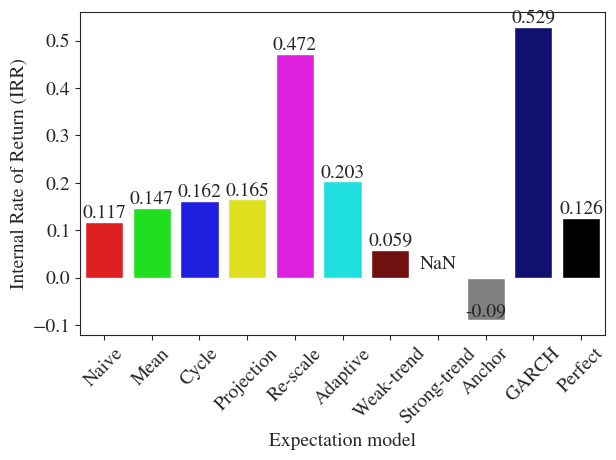

In [ ]:
plot_bar(results, labels, 'Expectation model', rotation=45)
plt.text(7, 0.01, 'NaN', ha='center', va='bottom')
plt.savefig('all_bar_irr.png', dpi=300, bbox_inches='tight')

In [ ]:
results = []
t_ds = ['2019-07', '2019-10', '2020-01', '2020-04', '2020-07', '2020-10', '2021-01', '2021-04', '2021-07', '2021-10', '2022-01', '2022-04', '2022-07', '2022-10', '2023-01', '2023-04']
x = 0
for t in t_ds:
  proforma_inputs_df.loc['t_d'] = t
  proforma_inputs_df.at[6, 'C_cc_model'] = cc_rescale_factors[x]
  proforma_inputs_df.at[6, 'C_rp_model'] = rp_rescale_factors[x]
  proforma_inputs_df.at[6, 'C_i_model'] = i_rescale_factors[x]
  x += 1
  test_proforma = proforma(proforma_inputs_df,
                         construction_cost_data_df=construction_cost_data_df, construction_cost_data_type='index', cc_price_base=275,
                         vacancy_data_df=vacancy_rates_data_df,
                         absorption_data_df=absorption_rate_data_df,
                         rent_data_df=rent_data_df,
                         sales_data_df=sales_data_df,
                         interest_rate_data_df=interest_rate_data_df)
  results.extend(test_proforma.run(scenarios, cc_expectation=True, vr_expectation=False, rp_expectation=True, i_expectation=True))

In [ ]:
results_df = pd.DataFrame()
for y in range(len(t_ds)):
  for i in range(len(scenarios)):
    results_df.at[t_ds[y], labels[i]] = results[i+11*(y)]

for i in range(len(scenarios)):
  results_df.at['2023-07', labels[i]] = results[0]

column_to_move = results_df['Perfect']
results_df = results_df.drop('Perfect', axis=1)
results_df['Perfect'] = column_to_move

In [ ]:
results_df = results_df.drop(['Strong-trend'], axis=1)

In [ ]:
results_df

,Naive model,Mean model,Cycle model,Projection model,Re-scale model,Adaptive model,Weak-trend,Anchor and adjust,Perfect expectations
2019-07,0.117450,0.146754,0.162212,0.164705,0.472336,0.203417,0.058983,-0.090033,0.125991
2019-10,0.112948,0.114444,0.115182,0.216546,0.430863,0.147775,0.109956,0.134824,0.125991
2020-01,0.090261,0.097898,0.101711,0.243247,0.370559,0.125177,0.075194,0.061553,0.125991
2020-04,-0.006324,0.016190,0.034239,0.248660,0.235065,0.103386,-0.072189,-0.315203,0.125991
2020-07,0.105271,0.059696,0.037890,0.268275,0.316438,0.038341,0.172796,0.347637,0.125991
2020-10,0.339421,0.265506,0.218500,0.330802,0.520109,0.106912,0.460222,0.740450,0.125991
2021-01,0.193102,0.238506,0.257026,0.318230,0.338529,0.253022,0.107945,-0.114481,0.125991
2021-04,0.181386,0.185017,0.187191,0.296411,0.299226,0.210424,0.174955,0.214202,0.125991
2021-07,0.307285,0.271771,0.255290,0.310321,0.399990,0.209580,0.364953,0.550703,0.125991
2021-10,0.307990,0.307807,0.307635,0.314065,0.379394,0.279635,0.308189,0.387296,0.125991


Text(0, 0.5, 'Internal Rate of Return (IRR)')

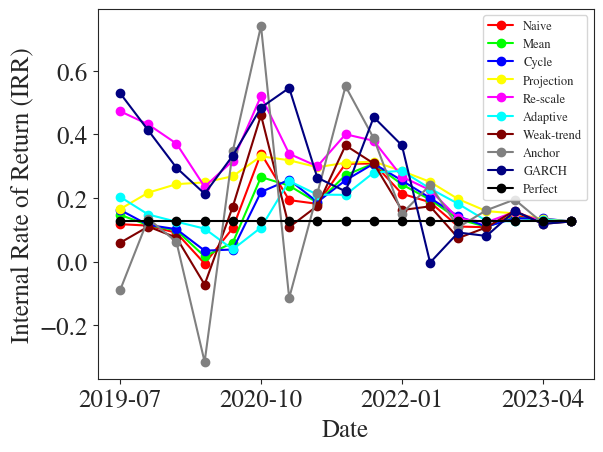

In [ ]:
colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#800000', '#808080', '#000080', 'black']
results_df.plot(marker='o', color=colors)
plt.legend(fontsize="9", loc ="upper right")
plt.xlabel('Date')
plt.ylabel('Internal Rate of Return (IRR)')

In [ ]:
# Sensitivity to interest rate (i)
i_range = [0, 0.1, 0.2, 0.3]
results = run_numerical_sensitivity('i', i_range, sheet_name='Scenarios_2', scenarios=scenarios,
                                    construction_cost_data_df=construction_cost_data_df,
                                    vacancy_data_df=vacancy_rates_data_df,
                                    absorption_data_df=absorption_rate_data_df,
                                    rent_data_df=rent_data_df,
                                    sales_data_df=sales_data_df,
                                    interest_rate_data_df=interest_rate_data_df,
                                    cc_expectation=True, vr_expectation=True, rp_expectation=False)

In [ ]:
column_order = [col for col in results.columns if col != 1] + [1]
results = results.reindex(columns=column_order)
labels = labels[1:] + [labels[0]]
scenarios = scenarios[1:] + [scenarios[0]]

Text(0.04, 0.01, 'i = 2.88%')

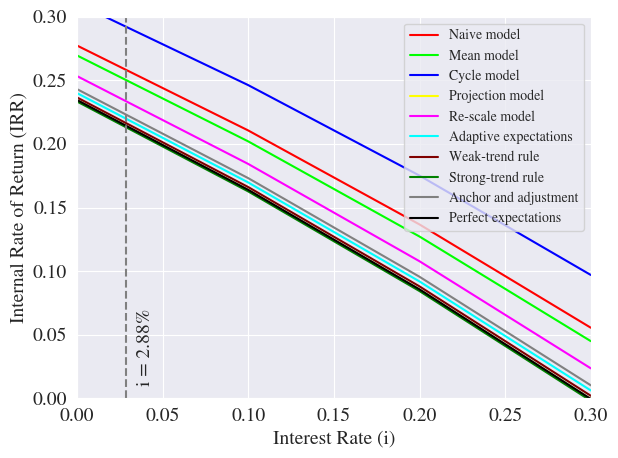

In [ ]:
plot_line(scenarios, results, labels, 'Interest Rate (i)', xlim=[0, 0.3], legsize=10, ylim=[0, 0.3])
plt.axvline(x=0.0288, color='gray', linestyle='--')
plt.text(0.04, 0.01, 'i = 2.88%', ha='center', va='bottom', rotation=90)

Text(0.04, 0.01, 'i = 2.88%')

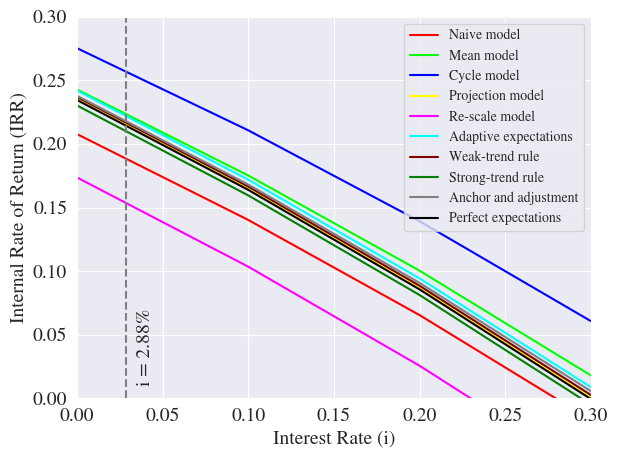

In [ ]:
plot_line(scenarios, results, labels, 'Interest Rate (i)', xlim=[0, 0.3], legsize=10, ylim=[0, 0.3])
plt.axvline(x=0.0288, color='gray', linestyle='--')
plt.text(0.04, 0.01, 'i = 2.88%', ha='center', va='bottom', rotation=90)

In [ ]:
# Sensitivity to construction costs (tau)
i_range = [160, 180, 200, 220, 240]
results = run_numerical_sensitivity('tau', i_range, sheet_name='Scenarios_2', scenarios=scenarios,
                                    construction_cost_data_df=construction_cost_data_df,
                                    vacancy_data_df=vacancy_rates_data_df,
                                    absorption_data_df=absorption_rate_data_df,
                                    rent_data_df=rent_data_df,
                                    sales_data_df=sales_data_df,
                                    interest_rate_data_df=interest_rate_data_df,
                                    cc_expectation=False, vr_expectation=True, rp_expectation=True)

Text(196, 0.03, 'τ = 198.44')

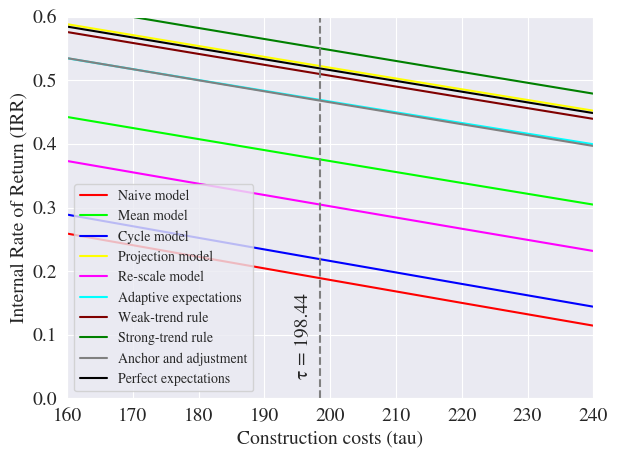

In [ ]:
plot_line(scenarios, results, labels, 'Construction costs (tau)', xlim=[160, 240], legsize=10, ylim=[0, 0.6])
plt.axvline(x=198.44, color='gray', linestyle='--')
plt.text(196, 0.03, '\u03C4 = 198.44', ha='center', va='bottom', rotation=90)

In [ ]:
# Sensitivity to unit sales price (pi)
i_range = [700000, 800000, 900000, 1000000, 1100000, 1200000]
results = run_numerical_sensitivity('pi', i_range, sheet_name='Scenarios_2', scenarios=scenarios,
                                    construction_cost_data_df=construction_cost_data_df,
                                    vacancy_data_df=vacancy_rates_data_df,
                                    absorption_data_df=absorption_rate_data_df,
                                    rent_data_df=rent_data_df,
                                    sales_data_df=sales_data_df,
                                    interest_rate_data_df=interest_rate_data_df,
                                    cc_expectation=True, vr_expectation=True, rp_expectation=False)

Text(930332, 0.3, 'π = $944,332')

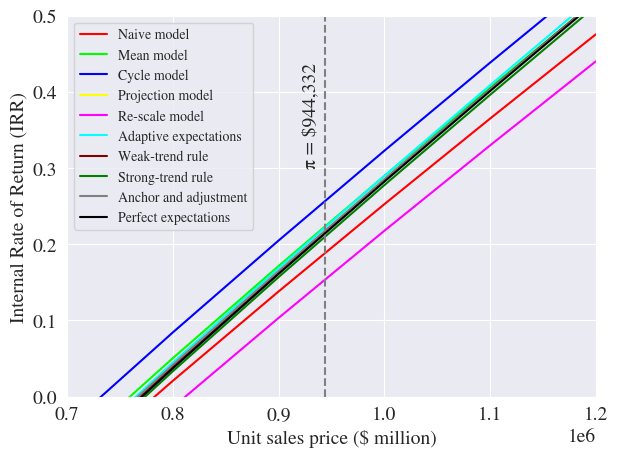

In [ ]:
plot_line(scenarios, results, labels, 'Unit sales price ($ million)', xlim=[700000, 1200000], legsize=10, ylim=[0, 0.5])
plt.axvline(x=944332, color='gray', linestyle='--')
plt.text(930332, 0.3, '\u03C0 = $944,332', ha='center', va='bottom', rotation=90)

Text(930332, 0.3, 'π = $944,332')

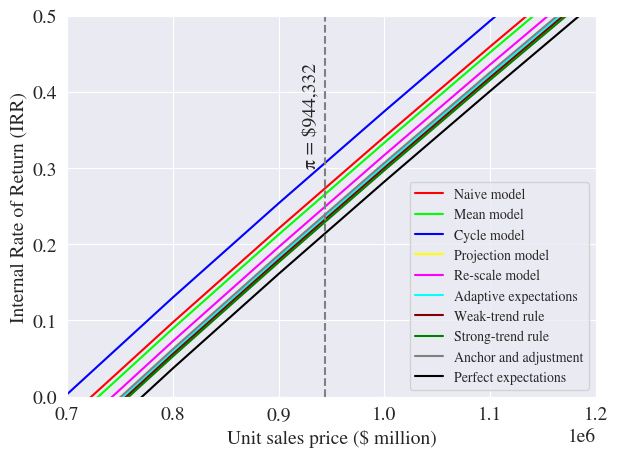

In [ ]:
plot_line(scenarios, results, labels, 'Unit sales price ($ million)', xlim=[700000, 1200000], legsize=10, ylim=[0, 0.5])
plt.axvline(x=944332, color='gray', linestyle='--')
plt.text(930332, 0.3, '\u03C0 = $944,332', ha='center', va='bottom', rotation=90)

In [ ]:
# Sensitivity to market absorption rate (omega)
i_range = [0, 0.2, 0.4, 0.6, 0.8, 0.933, 1]
results = run_numerical_sensitivity('omega', i_range, sheet_name='Scenarios_2', scenarios=scenarios,
                                    construction_cost_data_df=construction_cost_data_df,
                                    vacancy_data_df=vacancy_rates_data_df,
                                    absorption_data_df=absorption_rate_data_df,
                                    rent_data_df=rent_data_df,
                                    sales_data_df=sales_data_df,
                                    interest_rate_data_df=interest_rate_data_df,
                                    cc_expectation=True, vr_expectation=False, rp_expectation=False)

Text(0.94, 0.02, 'ω = 93.3%')

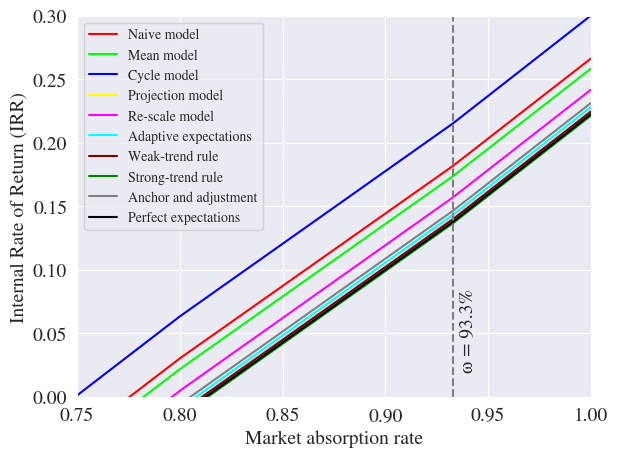

In [ ]:
plot_line(scenarios, results, labels, 'Market absorption rate', xlim=[0.75, 1], legsize=10, ylim=[0, 0.3])
plt.axvline(x=0.933, color='gray', linestyle='--')
plt.text(0.94, 0.02, '\u03C9 = 93.3%', ha='center', va='bottom', rotation=90)

# 5 Joint Sensitivity: Change in interest rates and sales price

Pearson correlation coefficient: 0.5500412438997463
P-value: 0.022161113582760388


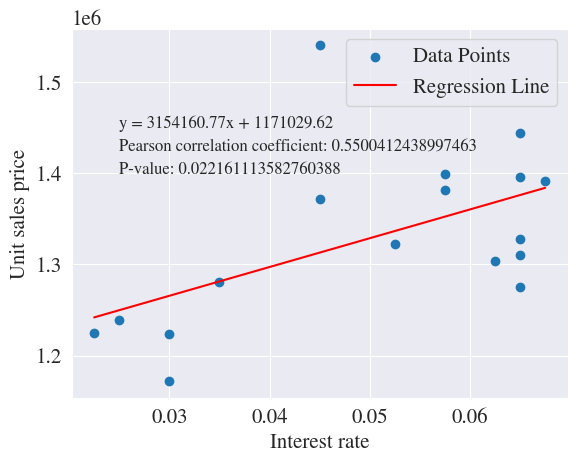

In [ ]:
# data correlation

x = interest_rate_data_df['Interest rate'][264:281]
y = sales_data_df['Average'][385:402]


# Calculate the Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(x, y)

print("Pearson correlation coefficient:", correlation_coefficient)
print("P-value:", p_value)


# Perform linear regression
coefficients = np.polyfit(x, y, 1)  # Fit a first-degree polynomial (linear regression)
regression_line = np.poly1d(coefficients)  # Create the regression line function

# Scatter plot
plt.scatter(x, y, label='Data Points')

# Regression line
plt.plot(x, regression_line(x), color='red', label='Regression Line')

# Add the equation of the regression line as text
slope = coefficients[0]
intercept = coefficients[1]
equation_text = f'y = {slope:.2f}x + {intercept:.2f}'
plt.text(0.025, 1450000, equation_text, fontsize=12)
plt.text(0.025, 1425000, "Pearson correlation coefficient: {}".format(correlation_coefficient), fontsize=12)
plt.text(0.025, 1400000, "P-value: {}".format(p_value), fontsize=12)

plt.xlabel('Interest rate')
plt.ylabel('Unit sales price')
plt.legend()

In [ ]:
# Assuming the following distribution functions for the variables with the uncertainty:
variables = {'i': ['uniform', 0.0075, 0.0675], 'pi': ['uniform', 860000, 1160000]}
initial_iterations = 8
initial_results = montecarlo_simulation(initial_iterations, variables, 1,
                                        proforma_inputs_df=proforma_inputs_df,
                                        construction_cost_data_df=construction_cost_data_df,
                                        vacancy_data_df=vacancy_rates_data_df,
                                        absorption_data_df=absorption_rate_data_df,
                                        rent_data_df=rent_data_df,
                                        sales_data_df=sales_data_df,
                                        interest_rate_data_df=interest_rate_data_df,
                                        cc_expectation=True, vr_expectation=False, rp_expectation=False, i_expectation=False)
req_it = required_iterations(initial_results)
print('{} runs are required to achive 95% confident level based on the initial experiments  . . .'.format(int(req_it+1)))

52526 runs are required to achive 95% confident level based on the initial experiments  . . .


In [ ]:
req_it = 5000
# Perfect expectation of cc expectation
print('Starting simulation . . .')
start = t.perf_counter()

results_1 = montecarlo_simulation(int(req_it+1), variables, 1,
                                  proforma_inputs_df=proforma_inputs_df,
                                  construction_cost_data_df=construction_cost_data_df,
                                  vacancy_data_df=vacancy_rates_data_df,
                                  absorption_data_df=absorption_rate_data_df,
                                  rent_data_df=rent_data_df,
                                  sales_data_df=sales_data_df,
                                  interest_rate_data_df=interest_rate_data_df,
                                  cc_expectation=True, vr_expectation=False, rp_expectation=False, i_expectation=False)

finish = t.perf_counter()
print('Simulation completed in {0} seconds . . .'.format(round(finish - start, 2)))

Starting simulation . . .
Simulation completed in 857.49 seconds . . .


In [ ]:
req_it = 5000
# Naive model of cc expectation
print('Starting simulation . . .')
start = t.perf_counter()

results_2 = montecarlo_simulation(int(req_it+1), variables, 2,
                                  proforma_inputs_df=proforma_inputs_df,
                                  construction_cost_data_df=construction_cost_data_df,
                                  vacancy_data_df=vacancy_rates_data_df,
                                  absorption_data_df=absorption_rate_data_df,
                                  rent_data_df=rent_data_df,
                                  sales_data_df=sales_data_df,
                                  interest_rate_data_df=interest_rate_data_df,
                                  cc_expectation=True, vr_expectation=False, rp_expectation=False, i_expectation=False)

finish = t.perf_counter()
print('Simulation completed in {0} seconds . . .'.format(round(finish - start, 2)))

Starting simulation . . .
Simulation completed in 1425.35 seconds . . .


In [ ]:
# Projection model of cc expectation
print('Starting simulation . . .')
start = t.perf_counter()

results_5 = montecarlo_simulation(int(req_it+1), variables, 5,
                                  proforma_inputs_df=proforma_inputs_df,
                                  construction_cost_data_df=construction_cost_data_df,
                                  vacancy_data_df=vacancy_rates_data_df,
                                  absorption_data_df=absorption_rate_data_df,
                                  rent_data_df=rent_data_df,
                                  sales_data_df=sales_data_df,
                                  interest_rate_data_df=interest_rate_data_df,
                                  cc_expectation=True, vr_expectation=False, rp_expectation=False, i_expectation=False)

finish = t.perf_counter()
print('Simulation completed in {0} seconds . . .'.format(round(finish - start, 2)))

Starting simulation . . .
Simulation completed in 2209.92 seconds . . .


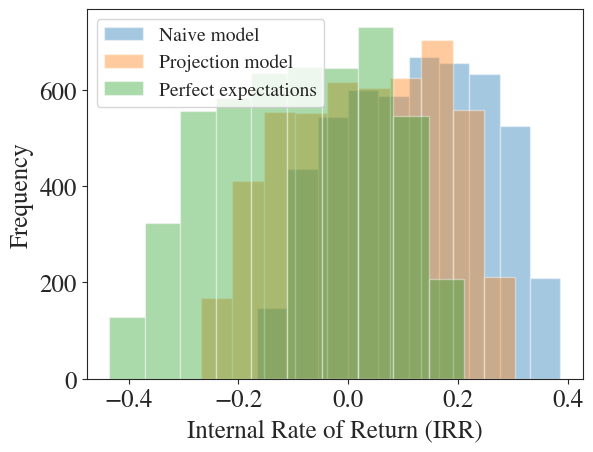

In [ ]:
plot_hist([results_2, results_5, results_1], labels=['Naive model', 'Projection model', 'Perfect expectations'], legsize=14)

In [ ]:
variables_grid = {'i': [0.0675, 0.0575, 0.0475, 0.0375, 0.0275, 0.0175, 0.0075],
                  'pi': [1005833-4*95000, 1005833-3*95000, 1005833-2*95000, 1005833-1*95000, 1005833, 1005833+95000, 1005833+2*95000, 1005833+3*95000, 1005833+4*95000]}
# [855833, 905833, 955833, 1005833, 1055833, 1105833, 1155833]
def run_joint_numerical_sensitivity(variables_grid, scenario_number, proforma_inputs_df,
                                    construction_cost_data_df,
                                    vacancy_data_df,
                                    absorption_data_df,
                                    rent_data_df,
                                    sales_data_df,
                                    interest_rate_data_df,
                                    cc_expectation=False, vr_expectation=False, rp_expectation=False, i_expectation=False):
  results_df = pd.DataFrame()
  variable_1 = list(variables_grid.keys())[0]
  variable_2 = list(variables_grid.keys())[1]
  for i in variables_grid[variable_1]:
    for pi in variables_grid[variable_2]:
      proforma_inputs_df[scenario_number][variable_1] = i
      proforma_inputs_df[scenario_number][variable_2] = pi
      test_proforma = proforma(proforma_inputs_df,
                          construction_cost_data_df=construction_cost_data_df, construction_cost_data_type='index', cc_price_base=275,
                          vacancy_data_df=vacancy_rates_data_df,
                          absorption_data_df=absorption_rate_data_df,
                          rent_data_df=rent_data_df,
                          sales_data_df=sales_data_df,
                          interest_rate_data_df=interest_rate_data_df)
      irr = test_proforma.run(scenario_number, cc_expectation=cc_expectation, vr_expectation=vr_expectation, rp_expectation=rp_expectation, i_expectation=i_expectation)
      results_df.at[i, pi] = irr
  return results_df

def plot_heatmap(data, x_label, y_label, z_label='Internal Rate of Return (IRR)', cmap='coolwarm', vmin=None, vmax=None):
  fig, ax = plt.subplots(figsize=[11, 6])
  heatmap = sns.heatmap(data, annot=True, vmin=vmin, vmax=vmax, cmap=cmap)
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)
  # Format the x-axis tick labels as prices with separators
  heatmap.set_xticklabels(['{:,.2f}'.format(x/1e6).format(x) for x in data.columns])
  colorbar = heatmap.collections[0].colorbar
  colorbar.set_label(z_label)

In [ ]:
joint_sen_results = {}
for scenario_number in [2]: #scenarios:
  joint_sen_results['results_{}'.format(scenario_number)] = run_joint_numerical_sensitivity(variables_grid, scenario_number,
                                                            proforma_inputs_df=proforma_inputs_df,
                                                            construction_cost_data_df=construction_cost_data_df,
                                                            vacancy_data_df=vacancy_rates_data_df,
                                                            absorption_data_df=absorption_rate_data_df,
                                                            rent_data_df=rent_data_df,
                                                            sales_data_df=sales_data_df,
                                                            interest_rate_data_df=interest_rate_data_df,
                                                            cc_expectation=True, vr_expectation=False, rp_expectation=False, i_expectation=False)

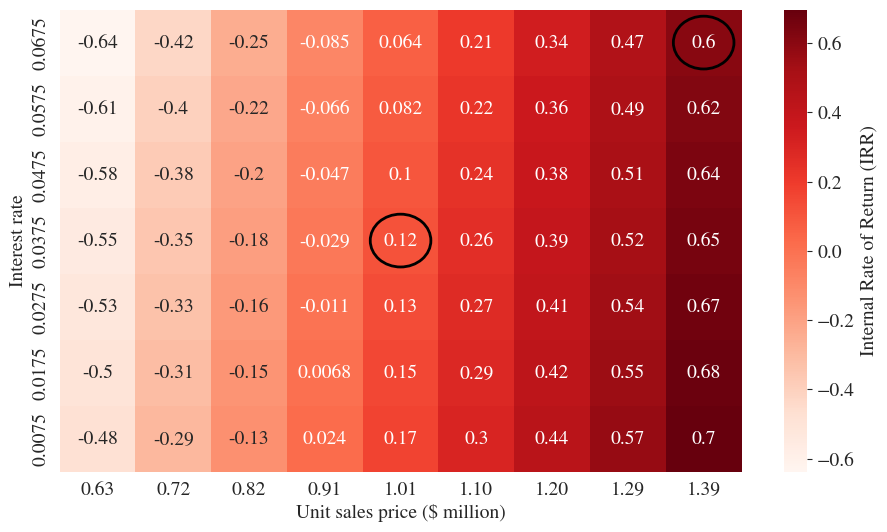

In [ ]:
# Naive model of cc
plot_heatmap(joint_sen_results['results_2'], 'Unit sales price ($ million)', 'Interest rate', cmap='Reds')
circle1 = patches.Circle((4.5, 3.5), radius=0.4, edgecolor='black', facecolor='none', lw=2)
circle2 = patches.Circle((8.5, 0.5), radius=0.4, edgecolor='black', facecolor='none', lw=2)
ax = plt.gca()
ax.add_patch(circle1)
ax.add_patch(circle2)